# Models VI: Interactions and Multicollinearity

## Revisiting the Advertising dataset

At the end of the last notebook we provided you with a challenge using the advertising dataset.  
Specifically we asked you to fit a model that included an interaction between `tv` and `radio` and then explore the **correlations** between predictors with and without **centering**.  

Let's take a further look here:

| Variable   | Description                     |
|------------|---------------------------------|
| tv     | TV ad spending in $1000 of  dollars            |
| radio     | Radio ad spending in $1000 of  dollars            |
| newspaper     | Newspaper ad spending in $1000 of  dollars            |
| sales     | Sales generated in $1000 of  dollars            |

We'll load up the data

In [1]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from helpers import plot_predictor_correlations
df = pl.read_csv('./data/advertising.csv')
df.head()

tv,radio,newspaper,sales
f64,f64,f64,f64
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9


And then fit 2 models with the same parameters:
- One **without** centering our predictors
- One **with** centering our predictors

In [3]:
# Uncentered
model = ols('sales ~ tv * radio', data=df.to_pandas())
results = model.fit()

# Centered
model_centered = ols('sales ~ center(tv) * center(radio)', data=df.to_pandas())
results_centered = model_centered.fit()

Let's look at the correlations between the predictors in each model. The helper function we provided you `plot_predictor_correlations` will do this by looking at the correlations between the columns of each model's **design matrix** $X$

When we look at the *uncentered* model we see that the interaction term `tv:radio` is highly correlated with both `tv` and `radio` - **this makes sense** - the product of 2 continuous variables is going to increase/decrease if *either* of the variables increase/decrease.

<Axes: title={'center': 'Correlation Matrix of Predictors'}>

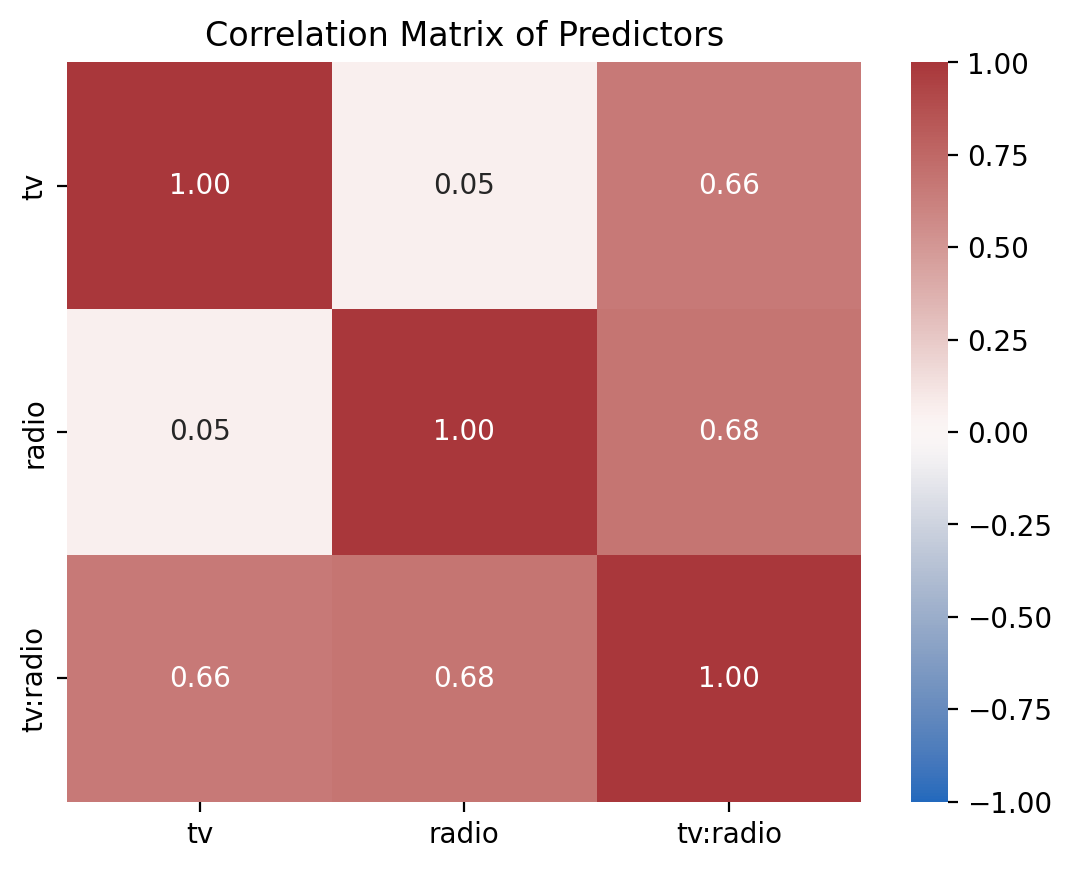

In [4]:
plot_predictor_correlations(model)

But when we look at the *uncentered* model we see that the correlations have now been reduced!

<Axes: title={'center': 'Correlation Matrix of Predictors'}>

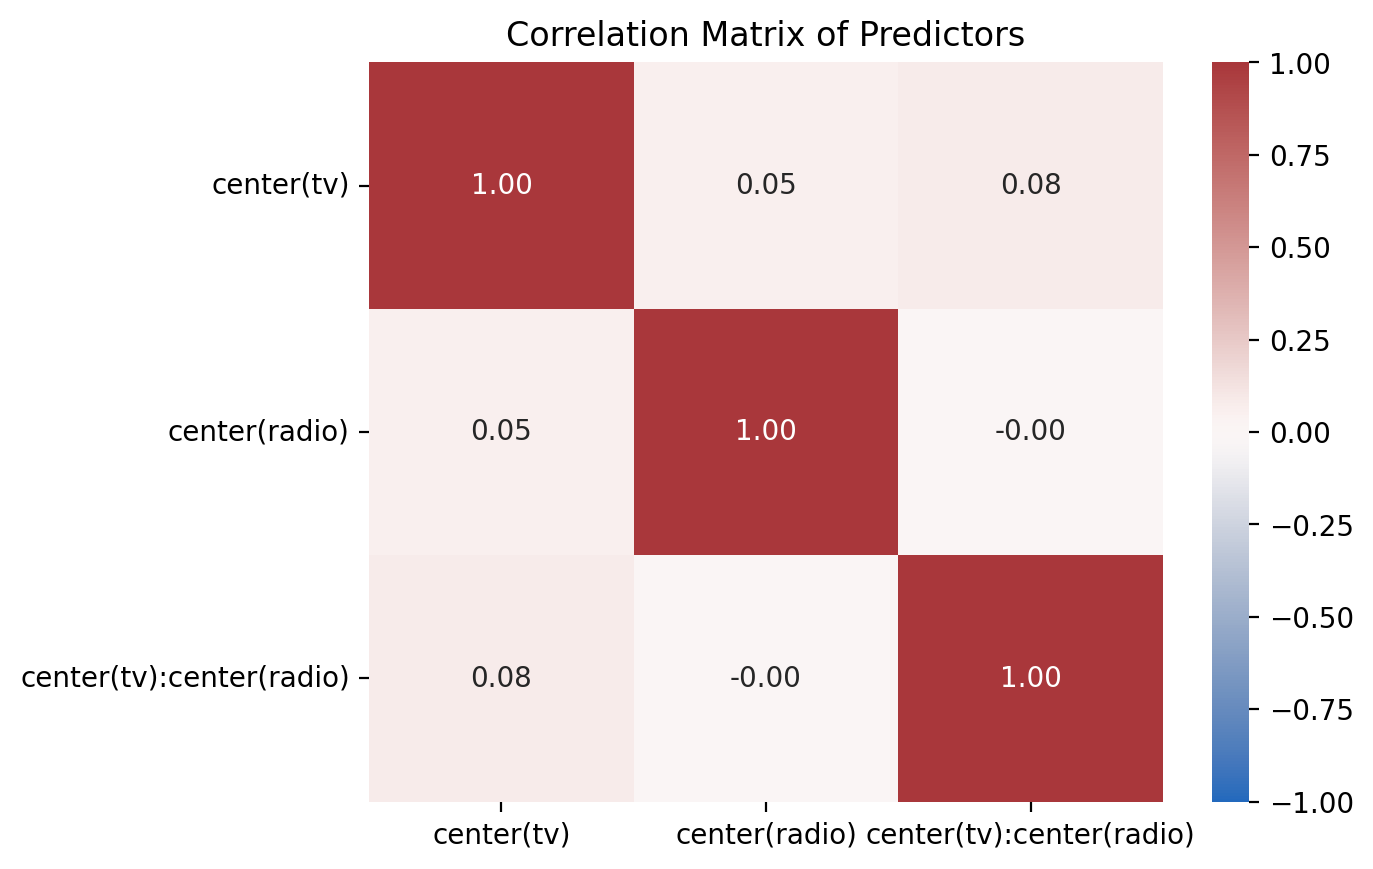

In [5]:
plot_predictor_correlations(model_centered)

Let's try to understand **why** this matters by revisiting one of the assumptions of the GLM we haven't discussed yet: **multicollinearity**.

## Multicollinearity - the other assumption

<div align="center">
<img src="./figs/mc.png" width="40%" alt="Figure 1">
</div>


Previously we discussed the fundamental assumptions of GLMs that can be summarized as **i**ndependent & **i**identically **d**istributed errors (**iid**):
- errors should be independent of each other
- errors should be independent of predictors
- errors should be approximately normal

Now let's explore **multicollinearity** - a situation in which the predictors of a GLM are **correlated** with each other. How correlated? There isn't actually a principled answer for this because it depends on the goals of your analysis!  

Instead in this notebook we'll explore the key points you should understand about this assumption:

- Why it matters
- How it affects parameter estimates
- How it affects estimate uncertainty (standard-errors & confidence intervals)
- How to check for it
- How to deal with it

We'll also ask you to skim the following paper which provides a more detailed discussion of what (and what not to) worry about when it comes to multicollinearity:

[Vanhove, J. (2021). Collinearity isn’t a disease that needs curing. Meta-Psychology, 5.](https://paperpile.com/shared/sM2u33xdnTMGoFTl59avK1Q)


## Why it matters

<div align="center">
<img src="./figs/x1.png" width="30%" alt="Figure 1">
<img src="./figs/x12.png" width="30%" alt="Figure 1">
<img src="./figs/x12c.png" width="30%" alt="Figure 1">
</div>

Intuitively, collinearity matters because in the *worst case*, when 2 or more predictors are *perfectly correlated*, we **can't tell the difference** between how much 2 or more variables uniquely predict $y$!

In the figures above, the overlap in circles shows how much $X1$ and $X2$ predict $y$ and how much overlap (corelation) exists between $X1$ and $X2$. In the right most figure, we see that $X1$ and $X2$ are so overlapping that it doesn't even make sense to use both of them in the same model!

In linear algebra terms:
- If any of the predictors in $X$ is a perfect linear combination of the other predictors, we say that $X$ is **rank-deficient** - it doesn't need as many columns as it has to reflect the overall variance that it does
- In this case, there is no unique solution for $\hat{\beta}$, because the matrix $ (X^TX)^{-1} $ is not invertible.

Let's see this with some 3d plots of a multiple regression with 2 predictors X1 and X2

Remember that graphically, fitting a *multiple regression* with 2 predictors is extending the idea of a **line** of best fit to a **plane** or **sheet** of best fit.

In this first movie X1 and X2 are uncorrelated and we can see that the regression plane is stable across repeated samples

![Regression with 2 predictors](figs/movie_regression_2preds.gif)

In the second, the two predictors are correlated.  The regression plane tips on a ridge defined by the correlated predictors, and is unstable across repeated samples:

![Regression with 2 predictors](figs/movie_regression_colinear.gif)



## Key Takeaways
In general we want to avoid multi-collinearity because it makes it harder to identify the unique contribution of each predictor in our GLM. Concretely we'll see this reflected in our calculations in the following ways:
- Our parameter estimates can become very large and even flip sign from negative to positive
- Our *uncertainty* in those estimates becomes larger so our standard errors *always* increase
- As a result our confidence intervals become *wider* 
- So our statistical *power* decreases - we're less certain of our estimates so our ability to make reliable conclusions given the same sample size *decreases*
- Our overall model fit *does not change* - in other words our error in predicting our dependent variable does not increase as a result of collinearity - but our model does get *less interpretable* - we can't pinpoint the unique contribution of each predictor!

You can see this reflected in the following figure just plotting the estimates and 95% confidence intervals for two predictors with varying levels of collinearity:

<div align="center">
<img src="./figs/collinear.png" width="70%" alt="Figure 1">
</div>

## Inspecting collinearity: VIF

We already saw one way of checking for collinearity: **visual inspection of predictor correlations**

We can also generalize this idea to calculate what's called a **variance inflation factor (VIF)** for each predictor in our model:

$$
\text{VIF}_k = \frac{1}{1-{R^2_{(-k)}}}
$$

where $R^2_{(-k)}$ refers to $R$-squared value you would get if you ran a regression using $X_k$ as the outcome variable, and all the other $X$ variables as the predictors. The idea here is that $R^2_{(-k)}$ is a very good measure of the extent to which $X_k$ is correlated with all the other variables in the model. Better yet, the square root of the VIF is pretty interpretable: it tells you how much wider the confidence interval for the corresponding coefficient $b_k$ is, relative to what you would have expected if the predictors are all nice and uncorrelated with one another. If you've only got two predictors, the VIF values are always going to be the same.


To calculate VIF we can use the `variance_inflation_factor()` function from `statsmodels`. However, this function only calculated VIF for a single predictor, so we'll write our own function (we've also provided it in `helpers.py` which you can import using: `from helpers import vif`) to calculate the VIFs for all of our predictors at once. We'll also return the square-root of the VIF to get a sense of how much wider our CIs would be:


In [ ]:
# Import statsmodels function
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Just showing you the code here

# For future just do: 
# from helpers import vif

def vif(model):
    """Calculate VIFs for all predictors in a model"""
    vifs = []
    for i in range(model.exog.shape[1]):
        this_vif = variance_inflation_factor(model.exog,i)
        vifs.append(this_vif)

    return pl.DataFrame({
        'variable': model.exog_names, 
        'VIF': vifs, 
        'CI_increase': np.sqrt(vifs)
        })

Let's use this to calculate the VIFs for our uncentered and centered models:

In [ ]:
# Uncentered
vif(model)

variable,VIF,CI_increase
str,f64,f64
"""Intercept""",13.803357,3.715287
"""tv""",3.727848,1.930764
"""radio""",3.907651,1.976778
"""tv:radio""",6.93786,2.633982


In [15]:
vif(model_centered)

variable,VIF,CI_increase
str,f64,f64
"""Intercept""",1.002983,1.00149
"""center(tv)""",1.010291,1.005132
"""center(radio)""",1.003058,1.001528
"""center(tv):center(radio)""",1.007261,1.003624


### VIF rule-of-thumb

So how should we interpret these? A decent **rule-of-thumb** is to be concerned about VIFs that are 5 or greater - **but this is not a hard-and-fast rule**.

Why 5? Because it means our estimates are going to be 2.5x as uncertain as they would have been with no collinearity. Is 2.5x the right number? It depends on how much *certainty* you need in your specific estimates and what kind of statistical inference you want to make. 

We can see that when we *don't center* our predictors - the *widths* of our confidence intervals are larger by a factor of about `np.sqrt(VIF)` for each predictor relative to our *centered* predictors:

In [ ]:
# Uncentered CIs
results.conf_int()

,0,1
Intercept,6.261383,7.239058
tv,0.016135,0.022067
radio,0.011298,0.046423
tv:radio,0.000983,0.001190


In [ ]:
# Uncentered widths
widths = results.conf_int()[1] - results.conf_int()[0]
widths

Intercept    0.977675
tv           0.005933
radio        0.035125
tv:radio     0.000207
dtype: float64

In [ ]:
# Centered CIs
results_centered.conf_int()

,0,1
Intercept,13.815204,14.078745
center(tv),0.042833,0.045922
center(radio),0.179723,0.197519
center(tv):center(radio),0.000983,0.001190


In [ ]:
# Centered Widths
widths_centered = results_centered.conf_int()[1] - results_centered.conf_int()[0]
widths_centered

Intercept                   0.263541
center(tv)                  0.003089
center(radio)               0.017796
center(tv):center(radio)    0.000207
dtype: float64

In [ ]:
# These look as wide as our uncentered predictors' CIs!

# Centered widths * sqrt(VIF)
widths_centered * vif(model).select('CI_increase').to_numpy().flatten()

Intercept                   0.979132
center(tv)                  0.005963
center(radio)               0.035179
center(tv):center(radio)    0.000545
dtype: float64

## Handling multi-collinearity

Aside from visual inspection or VIF calculations the most direct way you can handle multi-collinearity is to simply removing one or more variables from your model that are redundant with other variables!

A few other approaches we won't cover in details in this course:
- Creating new un-correlated predictors using [Principal Components Analysis (PCA)](https://scikit-learn.org/stable/modules/decomposition.html#pca)
- Adding *regularization* to OLS via [Ridge Regression](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification) which will force the model to keep $\beta$ values small
- Adding *regularization* to OLS via [Lasso Regression](https://scikit-learn.org/stable/modules/linear_model.html#lasso) which will force the model to set some of the $\beta$ values to zero

If the collinearity is because of **interactions** between variables that you've created - you can **center** or **z-score** each variable **before** calculating the interaction like we've seen before.

Let's explore this with a challenge:

## Challenge

Fit and explore a new model like the ones above (including an interaction) but this time z-score each predictor in the model:

1. Create new z-scored columns for `tv` and `radio` in your DataFrame and fit a new model using those columns those with `ols`
2. Fit a second model using the `standardize()` transformation in the model formula itself with the *original* columns; see how we used `center()` above - is there any difference?
3. Then use `plot_predictor_correlations` to visualize the correlations between predictors from either model. How does this compare to the uncentered and centered models?
4. In notebook `04_models` in the "Gram Matrix" section we created a histogram of 3 predictors. Recreate the histogram for the original and z-scored columns. How are they different?
5. Inspect the parameter estimate from the z-scored model. How would you interpret these compared to the *centered* model?


### 1) Create new z-scored columns and use them to fit a new model

In [ ]:
# Your code here

In [ ]:
# Solution
zscore = lambda name: (col(name) - col(name).mean()) / col(name).std()
df = df.with_columns(
    tv_z = zscore('tv'),
    radio_z = zscore('radio'),

)

In [85]:
model_z = ols('sales ~ tv_z * radio_z', data=df.to_pandas())
results_z = model_z.fit()

### 2) Fit another model using the original columns and `standardize()` in the formula
Is there any difference?

In [ ]:
# Your code here

In [84]:
# Solution
model_z_formula = ols('sales ~ standardize(tv) * standardize(radio)', data=df.to_pandas())
results_z_formula = model_z_formula.fit()


In [87]:
results_z.params

Intercept       13.946974
tv_z             3.809978
radio_z          2.800424
tv_z:radio_z     1.384913
dtype: float64

In [88]:
results_z_formula.params

Intercept                             13.946974
standardize(tv)                        3.800441
standardize(radio)                     2.793414
standardize(tv):standardize(radio)     1.377988
dtype: float64

### 3) Use `plot_predictor_correlations` to compare correlations between either z-scored model and the centered and uncentered models

In [ ]:
# Your code here

<Axes: title={'center': 'Correlation Matrix of Predictors'}>

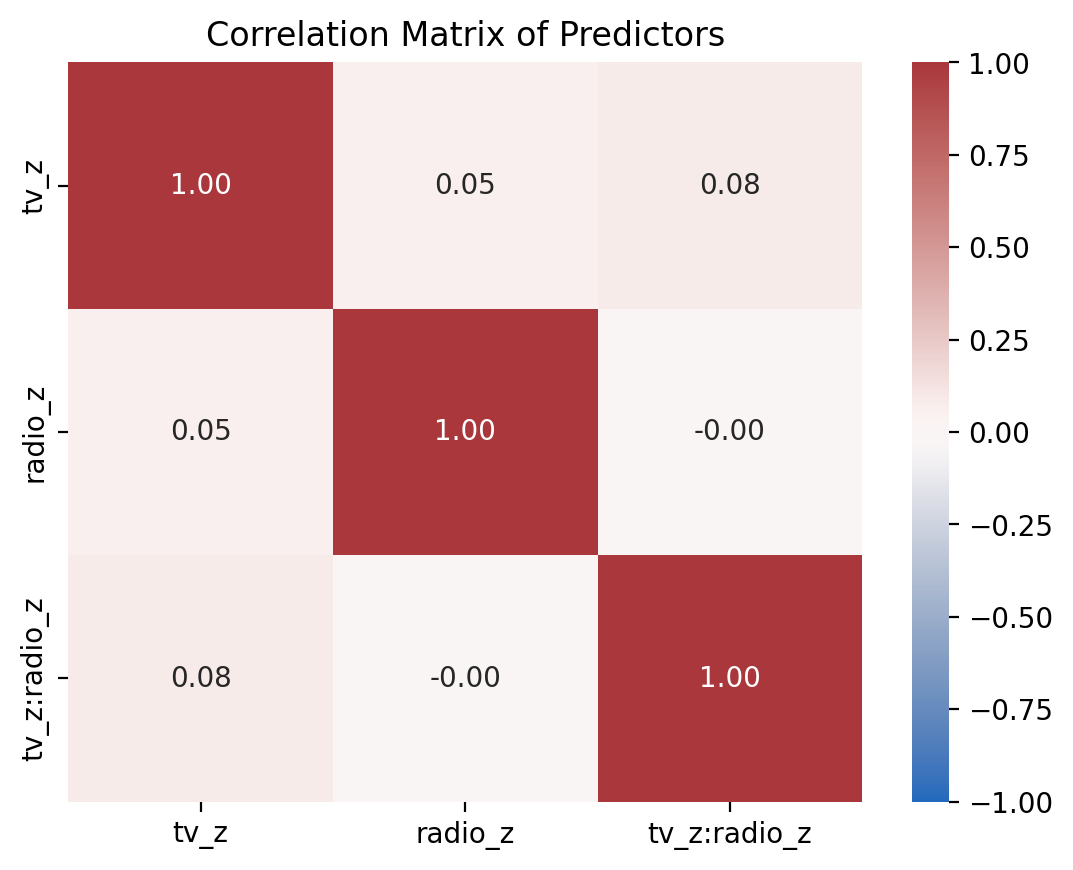

In [91]:
# Solution
plot_predictor_correlations(model_z)

<Axes: title={'center': 'Correlation Matrix of Predictors'}>

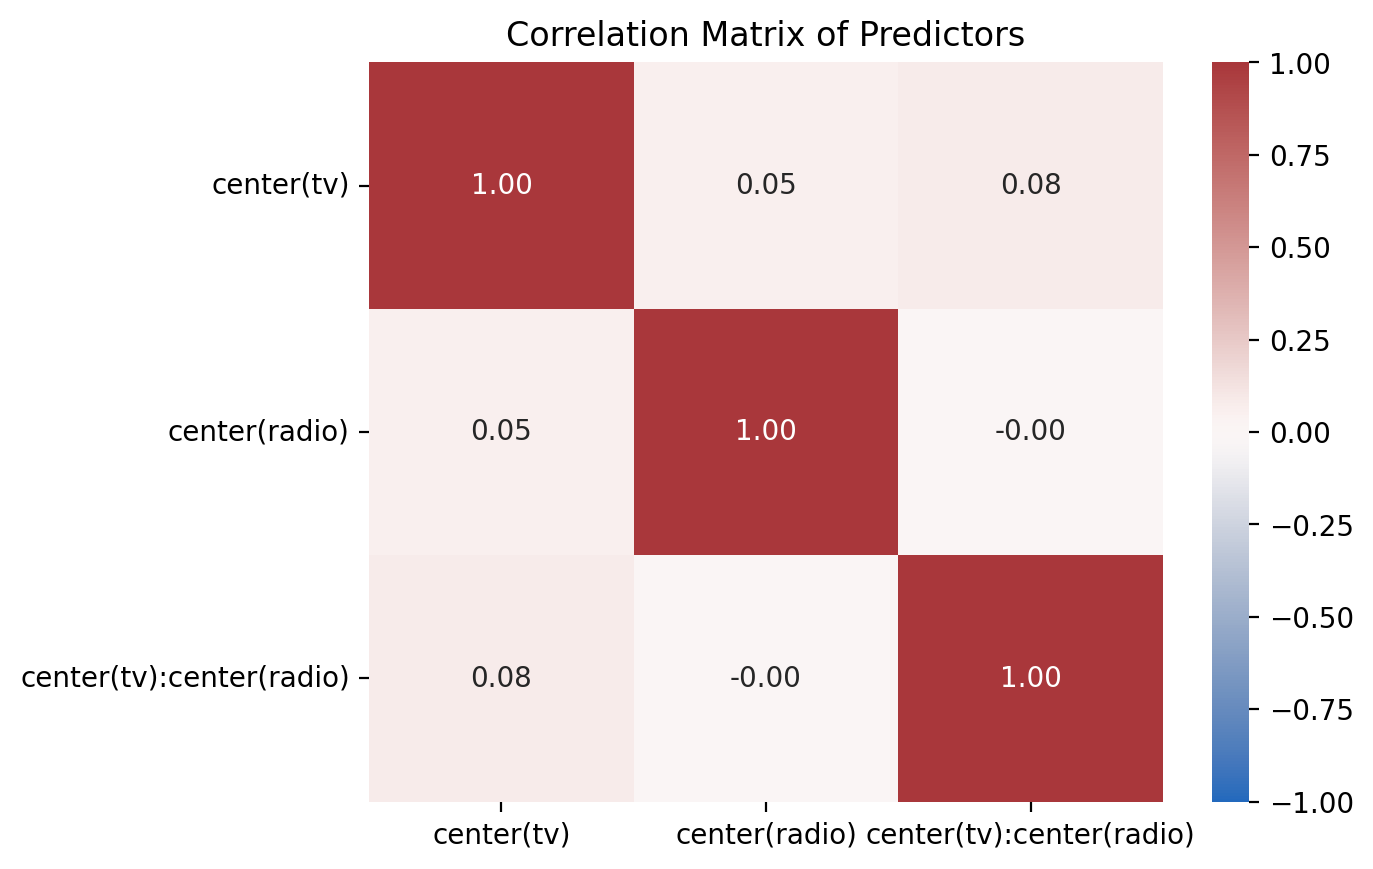

In [92]:
# Solution
plot_predictor_correlations(model_centered)

<Axes: title={'center': 'Correlation Matrix of Predictors'}>

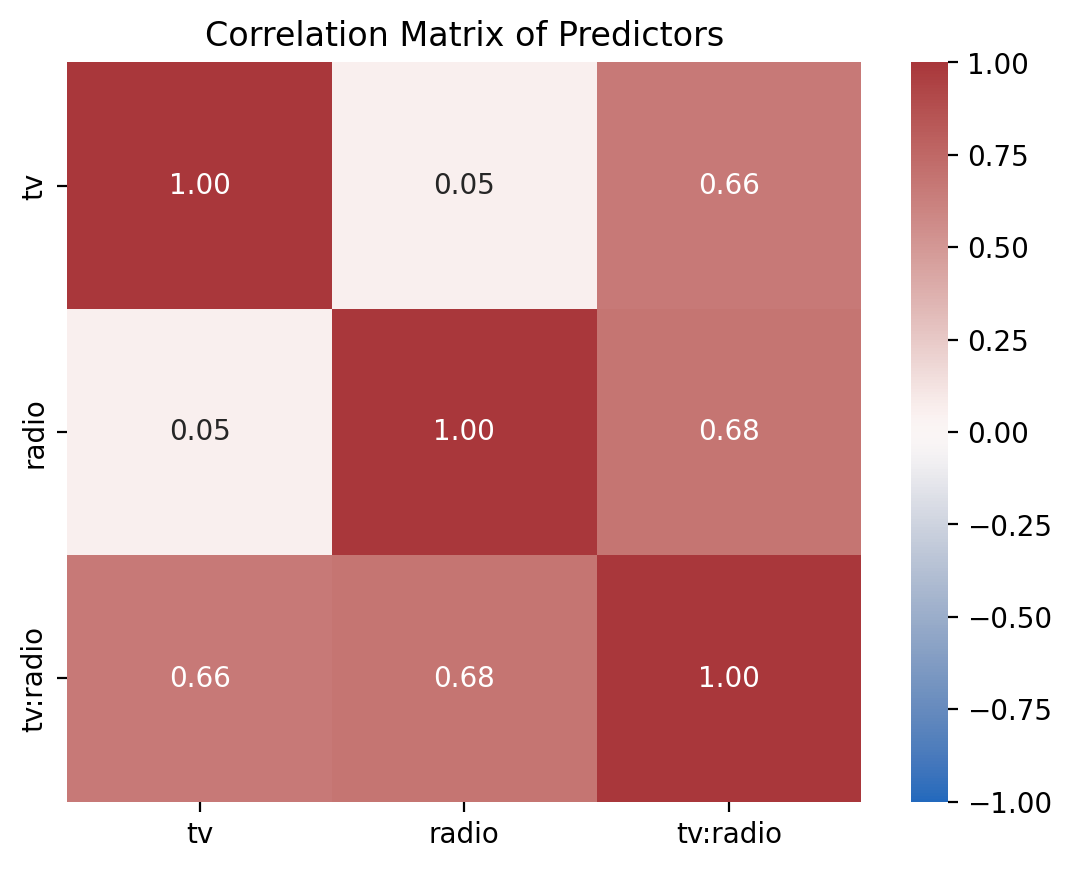

In [93]:
# Solution
plot_predictor_correlations(model)

How are they different?  

*Your response here*

### 4) Create a histogram of the z-scored predictors and compare it to a histogram of the original predictors

We've given you starter code below...

In [ ]:
# Plot from 04_models using raw data
ax=sns.histplot(data=df, x='tv', kde=False, label='TV')
ax=sns.histplot(data=df, x='radio', kde=False, label='Radio')
ax.legend();

In [ ]:
# Your code here

In [ ]:
# Solution
ax=sns.histplot(data=df, x='tv_z', kde=False, label='TV')
ax=sns.histplot(data=df, x='radio_z', kde=False, label='Radio')
ax.legend();

How are they different?  

*Your response here*

### 5) Compare parameter estimates from z-scored and centered models

In [ ]:
# Your code here

In [ ]:
# Solution
print(results_centered.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
No. Observations:                 200   F-statistic:                     1963.
Covariance Type:            nonrobust   Prob (F-statistic):          6.68e-146
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   13.9470      0.067    208.737      0.000      13.815      14.079
center(tv)                   0.0444      0.001     56.673      0.000       0.043       0.046
center(radio)                0.1886      0.005     41.806      0.000       0.180       0.198
center(tv):center(radio)     0.0011   5.24e-05     20.727      0.000       0.001       0.001

Notes:
[1] Standard Errors assume that the cov

In [ ]:
# Solution
print(model_scaled.fit().summary(slim=True)) 

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
No. Observations:                 200   F-statistic:                     1963.
Covariance Type:            nonrobust   Prob (F-statistic):          6.68e-146
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             13.9470      0.067    208.737      0.000      13.815      14.079
standardize(tv)                        3.8004      0.067     56.673      0.000       3.668       3.933
standardize(radio)                     2.7934      0.067     41.806      0.000       2.662       2.925
standardize(tv):standardize(radio)     1.3780      0.066     20.727      0.000       1.247

How would you interpret them in natural language?

*Your response here*